In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt 
from scipy import signal
from scipy import integrate
from scipy import ndimage
plt.style.use('cashaback_dark')
from tqdm import tqdm
import numba_scipy
import numba as nb
# import numba_special
import scipy.special as sc
from numba import njit

In [2]:
def simulate_conditioned_distribution(mu_x, sig_x, mu_y, sig_y, n_samples=1000000):
    # Generate random variables X and Y
    x = np.random.normal(mu_x, sig_x, size=n_samples)
    y = np.random.normal(mu_y, sig_y, size=n_samples)
    
    # Compute the values of X that are less than Y
    x_conditioned = x[x < y]
    
    # Compute the sample mean of the new distribution
    if len(x_conditioned) > 0:
        new_mu = np.mean(x_conditioned)
        new_sd = np.std(x_conditioned)
        new_skew = stats.skew(x_conditioned)
    else:
        new_mu = 0
        
    return x,y,x_conditioned,new_mu,new_sd,new_skew

In [3]:
def get_skew(EX,EX2,EX3):
    ans = (EX3 - 3*EX*(EX2 - EX**2) - EX**3)/((EX2 - EX**2)**(3/2))
    return ans
def get_variance(EX,EX2):
    return EX2 - EX**2

ONE TIME MEAN FUNCTION

In [4]:
@njit
def get_moments_single(timesteps,mu_x,mu_y,sig_x,sig_y):
    # xpdf = stats.norm.pdf(timesteps,mu_x,sig_x)
    xpdf = (1/(sig_x*np.sqrt(2*np.pi)))*np.e**((-0.5)*((timesteps-mu_x)/sig_x)**2)
    # prob_x_less_y = stats.norm.cdf(0,mu_x-mu_y,np.sqrt(sig_x**2 + sig_y**2))
    prob_x_less_y = (1 - sc.erf((mu_x-mu_y)/(np.sqrt(2)*np.sqrt(sig_x**2 + sig_y**2))))/2
    if prob_x_less_y == 0:
        ev,ev2,ev3 = 0,0,0
    else:
        y_integrated = np.empty(len(timesteps),dtype=np.float64)
        for i in range(len(timesteps)):
            t = timesteps[i]
            y_integrated[i] = (1 - sc.erf((t-mu_y)/(np.sqrt(2)*sig_y)))/2
        ev = np.sum(timesteps*xpdf*y_integrated)/prob_x_less_y
        ev2 = np.sum(timesteps**2*xpdf*y_integrated)/prob_x_less_y
        ev3 = np.sum(timesteps**3*xpdf*y_integrated)/prob_x_less_y
    
    return ev,ev2,ev3

LOOPING THROUGH ALL TIME MEANS

In [5]:
@njit(parallel=True)
def get_moments(timesteps,agent_means,time_means,agent_sds,time_sds):
    EX,EX2,EX3 = np.zeros((6,len(time_means))),np.zeros((6,len(time_means))),np.zeros((6,len(time_means)))
    EXG,EX2G,EX3G = np.zeros((6,len(time_means))),np.zeros((6,len(time_means))),np.zeros((6,len(time_means)))
    for i in nb.prange(6):
        mu_x = agent_means[i]
        sig_x = agent_sds[i]
        for j in range(len(time_means)):
            sig_y = time_sds[i]
            mu_y = time_means[j]
            
            # xpdf = stats.norm.pdf(timesteps,mu_x,sig_x)
            xpdf = (1/(sig_x*np.sqrt(2*np.pi)))*np.e**((-0.5)*((timesteps-mu_x)/sig_x)**2)
            # prob_x_less_y = stats.norm.cdf(0,mu_x-mu_y,np.sqrt(sig_x**2 + sig_y**2))
            prob_x_less_y = (sc.erfc((mu_x-mu_y)/(np.sqrt(2)*np.sqrt(sig_x**2 + sig_y**2))))/2
            prob_x_greater_y = (sc.erfc((mu_y-mu_x)/(np.sqrt(2)*np.sqrt(sig_x**2 + sig_y**2))))/2
            
            if prob_x_less_y == 0:
                pass
            else:
                y_integrated = np.empty(len(timesteps),dtype=np.float64)
                y_integrated_opposite = np.empty(len(timesteps),dtype=np.float64)
                for k in range(len(timesteps)):
                    t = timesteps[k]
                    y_integrated[k] = (sc.erfc((t-mu_y)/(np.sqrt(2)*sig_y)))/2
                    y_integrated_opposite[k] = sc.erfc((mu_y-t)/(np.sqrt(2)*sig_y))/2
                EX[i,j] = np.sum(timesteps*xpdf*y_integrated)/prob_x_less_y
                EX2[i,j] = np.sum(timesteps**2*xpdf*y_integrated)/prob_x_less_y
                EX3[i,j] = np.sum(timesteps**3*xpdf*y_integrated)/prob_x_less_y
                EXG[i,j] = np.sum(timesteps*xpdf*y_integrated_opposite)/prob_x_greater_y
                EX2G[i,j] = np.sum(timesteps**2*xpdf*y_integrated_opposite)/prob_x_greater_y
                EX3G[i,j] = np.sum(timesteps**3*xpdf*y_integrated_opposite)/prob_x_greater_y
        
    return EX,EX2,EX3,EXG,EX2G,EX3G

In [6]:
agent_means = np.array([1000,1000,1100,1100,1200,1200],dtype=float)
agent_sds = np.array([50,150,50,150,50,150],dtype=float)
time_means = np.arange(0,2000,1,dtype=float)
time_sds = np.array([100.0]*6)
timesteps = np.arange(0,5000,1,dtype=np.float64)
EX,EX2,EX3,EXG,EX2G,EX3G= get_moments(timesteps,agent_means,time_means,agent_sds,time_sds)

In [12]:
np.any(np.isnan(EX2))

False

In [7]:
mean,var,skew = EX,get_variance(EX,EX2),get_skew(EX,EX2,EX3)
sd = np.sqrt(var)
print(mean[0,1000])
print(sd[0,1000])
print(skew[0,1000])

982.1587588384724
46.70856574350412
-0.0239193308006054


In [8]:
mean,var,skew = EXG,get_variance(EXG,EX2G),get_skew(EXG,EX2G,EX3G)
sd = np.sqrt(var)
print(mean[0,1000])
print(sd[0,1000])
print(skew[0,1000])

1017.8412411615273
46.70856574352281
0.023919330811105095


In [9]:
agent_means = np.array([1000,1000,1100,1100,1200,1200],dtype=float)
agent_sds = np.array([50,150,50,150,50,150],dtype=float)
time_means = np.arange(0,2000,1,dtype=float)
time_sds = np.array([100.0]*6)
timesteps = np.arange(0,5000,1,dtype=np.float64)
ex1,ex2,ex3 = np.zeros((6,len(time_means))),np.zeros((6,len(time_means))),np.zeros((6,len(time_means)))
for i in range(6):
    mu_x = agent_means[i]
    sig_x = agent_sds[i]
    sig_y = time_sds[i]
    for j in range(len(time_means)):
        mu_y = time_means[j]
        ex1[i,j],ex2[i,j],ex3[i,j] = get_moments_single(timesteps,mu_x,mu_y,sig_x,sig_y)
        
mean2,var2,skew2 = ex1,get_variance(ex2,ex1),get_skew(ex1,ex2,ex3)
sd2 = np.sqrt(var)
print(mean2[0,1000])
print(sd2[0,1000])
print(skew2[0,1000])

982.1587588384724
46.70856574352281
-0.0239193308006054


C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_22492\1901837034.py:2: RuntimeWarning: invalid value encountered in power
  ans = (EX3 - 3*EX*(EX2 - EX**2) - EX**3)/((EX2 - EX**2)**(3/2))
C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_22492\1901837034.py:2: RuntimeWarning: invalid value encountered in true_divide
  ans = (EX3 - 3*EX*(EX2 - EX**2) - EX**3)/((EX2 - EX**2)**(3/2))


1017.8412411615273
46.70856574352281
0.023919330811105095
982.165778389803
46.735785010891135
-0.014570139103037881


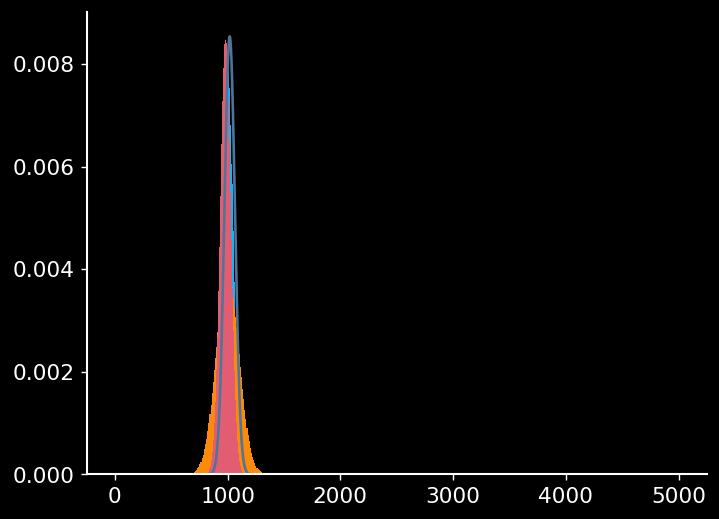

In [10]:
x,y,x_conditioned,new_mu,new_sd,new_skew = simulate_conditioned_distribution(1000, 50, 1000, 100)
print(mean[0,1000])
print(sd[0,1000])
print(skew[0,1000])


print(new_mu)
print(new_sd)
print(new_skew)
fig,ax = plt.subplots()
ax.hist(x,density=True,bins=100)
ax.hist(y,density=True,bins=100)
ax.hist(x_conditioned,density=True,bins=100)
ax.plot(stats.skewnorm.pdf(timesteps,skew[0,1000],mean[0,1000],sd[0,1000]))
plt.show()

# Use FFT convolution to get probability of making it 

Need to convolve the reaction movement time distribution with the new agent distribution

Get mean,sd,skew

In [11]:
agent_means = np.array([1000,1000,1100,1100,1200,1200],dtype=float)
agent_sds = np.array([50,150,50,150,50,150],dtype=float)
time_means = np.arange(0,2000,1,dtype=float)
time_sds = np.array([100.0]*6)
timesteps = np.arange(0,5000,1,dtype=np.float64)
EX,EX2,EX3 = get_moments(timesteps,agent_means,time_means,agent_sds,time_sds)
mean,var,skew = EX,get_variance(EX,EX2),get_skew(EX,EX2,EX3)
sd = np.sqrt(var)
print(mean[0,1000])
print(sd[0,1000])
print(skew[0,1000])

ValueError: too many values to unpack (expected 3)

Convolve

In [ ]:
conv_timesteps = np.arange(-5000,5000,1)
reg_timesteps = np.arange(0,2000,1)
new_agent_pdf = stats.skewnorm.pdf(reg_timesteps,skew,mean,sd)
new_agent_pdf[:,:300] = [0]*300 # First 300 should be zero, but shit get's weird at the edge cases

reaction_movement_pdf = stats.norm.pdf(conv_timesteps,400,100)
reaction_movement_cdf = stats.norm.cdf(conv_timesteps,400,100)
reaction_reach_pdf = np.zeros((6,10000))
prob_reaction_indecision = np.zeros((6,10000))
for i in range(6):
    reaction_reach_pdf[i,:] = np.convolve(new_agent_pdf[i,:],reaction_movement_pdf,mode='same')
    prob_reaction_indecision[i,:] = np.nansum(reaction_reach_pdf[:,abs(np.min(conv_timesteps))+1500:])

c:\Users\Seth Sullivan\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\Seth Sullivan\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [ ]:
prob_reaction_indecision

array([[2.98714751e-23, 2.98714751e-23, 2.98714751e-23, ...,
        2.98714751e-23, 2.98714751e-23, 2.98714751e-23],
       [5.45143005e-10, 5.45143005e-10, 5.45143005e-10, ...,
        5.45143005e-10, 5.45143005e-10, 5.45143005e-10],
       [5.45143005e-10, 5.45143005e-10, 5.45143005e-10, ...,
        5.45143005e-10, 5.45143005e-10, 5.45143005e-10],
       [1.52053255e-08, 1.52053255e-08, 1.52053255e-08, ...,
        1.52053255e-08, 1.52053255e-08, 1.52053255e-08],
       [1.52053255e-08, 1.52053255e-08, 1.52053255e-08, ...,
        1.52053255e-08, 1.52053255e-08, 1.52053255e-08],
       [2.98306743e-07, 2.98306743e-07, 2.98306743e-07, ...,
        2.98306743e-07, 2.98306743e-07, 2.98306743e-07]])

 ...]

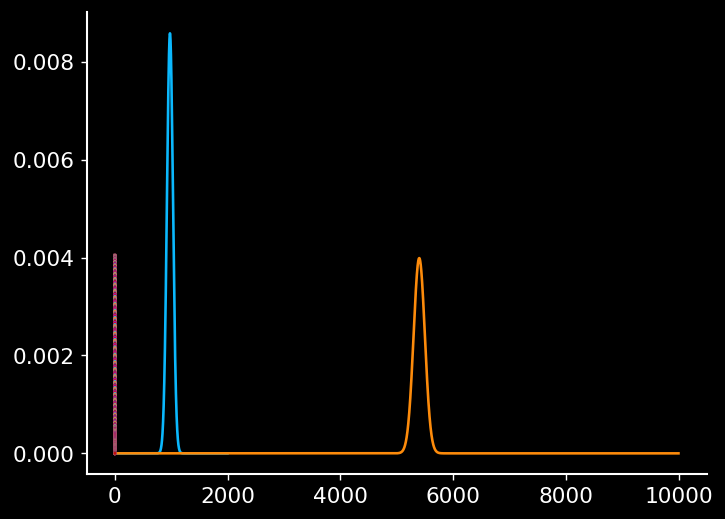

In [ ]:
plt.plot(new_agent_pdf[0,:])
plt.plot(reaction_movement_pdf[:])
plt.plot(reaction_reach_pdf[:])

# Ignoring the SKEW so I can just add means and sds

In [ ]:
agent_means = np.array([1000,1000,1100,1100,1200,1200],dtype=float)
agent_sds = np.array([50,150,50,150,50,150],dtype=float)
time_means = np.arange(0,2000,1,dtype=float)
time_sds = np.array([100.0]*6)
timesteps = np.arange(0,5000,1,dtype=np.float64)
EX,EX2,EX3 = get_moments(timesteps,agent_means,time_means,agent_sds,time_sds)
mean,var,skew = EX,get_variance(EX,EX2),get_skew(EX,EX2,EX3)
sd = np.sqrt(var)
print(mean[0,1000])
print(sd[0,1000])
print(skew[0,1000])

982.1587588384724
46.70856574350412
-0.0239193308006054


C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_477636\1901837034.py:2: RuntimeWarning: invalid value encountered in power
  ans = (EX3 - 3*EX*(EX2 - EX**2) - EX**3)/((EX2 - EX**2)**(3/2))
C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_477636\1901837034.py:2: RuntimeWarning: invalid value encountered in true_divide
  ans = (EX3 - 3*EX*(EX2 - EX**2) - EX**3)/((EX2 - EX**2)**(3/2))
C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_477636\3148066199.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(var)


In [ ]:
reaction_movement_mean = 400
reaction_movement_sd = 50

prob_reaction_indecision = 1 - stats.norm.cdf(1500,mean + reaction_movement_mean,np.sqrt(sd**2 + reaction_movement_sd**2))

In [ ]:
prob_reaction_indecision[0,1800]

0.07864960352475059

In [ ]:
def prob_making_based_on_agent_v2(timesteps,agent_means,agent_stds,timing_uncertainty,reaction_plus_movement_time,reaction_plus_movement_uncertainty):
        # Get first three central moments (EX2 is normalized for mean, EX3 is normalized for mean and sd) of the new distribution based on timing uncertainty
        inf_timesteps = np.arange(0,5000,1,dtype=np.float64)
        time_means = timesteps
        EX,EX2,EX3 = get_moments(inf_timesteps,agent_means,time_means,agent_stds,timing_uncertainty)
        new_mean,new_var,new_skew = EX,get_variance(EX,EX2),get_skew(EX,EX2,EX3)
        new_sd = np.sqrt(new_var)
        prob_make_reaction = stats.norm.cdf(1500,new_mean + reaction_plus_movement_time,np.sqrt(new_sd**2 + reaction_plus_movement_uncertainty**2))
        return prob_make_reaction

In [ ]:
a = prob_making_based_on_agent_v2(reg_timesteps,agent_means,agent_sds,time_sds,400,50)

C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_477636\1901837034.py:2: RuntimeWarning: invalid value encountered in power
  ans = (EX3 - 3*EX*(EX2 - EX**2) - EX**3)/((EX2 - EX**2)**(3/2))
C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_477636\1901837034.py:2: RuntimeWarning: invalid value encountered in true_divide
  ans = (EX3 - 3*EX*(EX2 - EX**2) - EX**3)/((EX2 - EX**2)**(3/2))
C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_477636\305985191.py:7: RuntimeWarning: invalid value encountered in sqrt
  new_sd = np.sqrt(new_var)


In [ ]:
a.shape

(6, 2000)